In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import operator
from PIL import Image 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from torchvision.transforms import ToTensor, RandomHorizontalFlip, Resize
from efficientnet_pytorch import EfficientNet
from transformers import AdamW, get_cosine_schedule_with_warmup
from albumentations import *
from albumentations.pytorch import ToTensor
from tqdm import tqdm
import json
import time
import config

In [ ]:
train_df = pd.read_csv('label_train.csv')

In [ ]:
train_df.head()

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, indices, transform=None):
        self.df = df
        self.indices = indices
        self.transform = transform
        
    def __getitem__(self, idx):
        image_ids = operator.itemgetter(*self.indices)(self.df['image_id'])
        labels = operator.itemgetter(*self.indices)(self.df['label'])
        
        image = Image.open(image_ids[idx])
        label = torch.tensor(labels[idx])
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.indices)

In [ ]:
transforms = {
            'train': torchvision.transforms.Compose(
                [
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.Resize((224, 224)),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]
                    )
                ]
            ),
            'valid': torchvision.transforms.Compose(
                [
                    torchvision.transforms.RandomHorizontalFlip(),
                    torchvision.transforms.Resize((224, 224)),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]
                    )
                ]
            ),
            'test': torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((224, 224)),
                    torchvision.transforms.ToTensor() 
                ]
            )
        }

In [11]:
def train_fn(epoch, train_dataloader, optimizer, criterion, scheduler, device):
    
    running_loss = 0
    total = 0
    tl = tqdm(train_dataloader)
    model.train()
    
    for batch_idx, (images, labels) in enumerate(tl, 1):
        
        optimizer.zero_grad()
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
    
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() 
    
        loss.backward()
        optimizer.step()
        
    avg_training_loss = running_loss/len(train_dataloader)
    
    return avg_training_loss
    
def valid_fn(epoch, valid_dataloader, criterion, device):
    
    running_loss = 0
    total = 0
    preds_acc = []
    labels_acc = []
    
    vl = tqdm(valid_dataloader)
    model.eval()
    
    for batch_idx, (images, labels) in enumerate(vl, 1):
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        
    avg_valid_loss = running_loss/len(valid_dataloader)
    return avg_valid_loss

In [ ]:

model = EfficientNet.from_pretrained('efficientnet-b3', num_classes=4)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

fold_results = {}
train_begin =time.time()

for fold, (train_idx, val_idx) in enumerate(StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=42
).split(
    train_df['image_id'].values, 
    train_df['label'].values
), 1):

    fold_begin = time.time()

    train_dataset = MyDataset(train_df, train_idx, transform=transforms['train'])
    valid_dataset = MyDataset(train_df, val_idx, transform=transforms['valid'])
    
    train_dataloader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
    
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=0.01, weight_decay=1e-3)
    num_train_steps = int(len(train_dataset) / config.BATCH_SIZE * config.EPOCHS)
    lr_scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=len(train_dataset) / config.BATCH_SIZE * 5,
        num_training_steps=num_train_steps
    )
    criterion = torch.nn.CrossEntropyLoss()
    
    best_loss = 1
    for epoch in range(config.EPOCHS):
        
        start = time.time()

        print('*'*15)
        print(f'FOLD: {fold} EPOCH: {epoch+1}')
        print('*'*15)
        
        print('Training.....')
        avg_train_loss = train_fn(epoch=epoch+1, 
                                  train_dataloader=train_dataloader, 
                                  optimizer=optimizer, 
                                  criterion=criterion,
                                  scheduler=lr_scheduler,
                                  device=device)
        
        print(f'Fold: {fold} | Epoch: {epoch+1} | Average Training loss: {avg_train_loss} |' 
              f' lr: {lr_scheduler.get_lr()}')
        
        lr_scheduler.step(avg_train_loss)
        
        with torch.no_grad():
            print('Validating....')
            avg_valid_loss = valid_fn(epoch=epoch+1, 
                                      valid_dataloader=valid_dataloader, 
                                      criterion=criterion, 
                                      device=device)

            print(f'Fold: {fold} | Epoch: {epoch+1} | Average Validation loss: {avg_valid_loss}')
            if avg_valid_loss < best_loss:
                best_loss = avg_valid_loss
                print('Saving best model....')
                torch.save(
                    {
                        'epoch': epoch, 
                        'best_loss': best_loss, 
                        'state_dict': model.state_dict()
                    },
                    f'efficientnet-b4.pt'
                )

        print(f'Epoch completed in {(time.time() - start)/60} minutes')

        results = {
            'train_loss': avg_train_loss,
            'valid_loss': avg_valid_loss,
            'lr': lr_scheduler.get_lr()
        }
        
        fold_results[f'Fold-{fold}-Epoch-{epoch+1}'] = results
        with open('fold_results-v2.json', 'a+') as file:
            json.dump(fold_results, file)
    
    print(f'Fold completed in: {(time.time() - fold_begin)/60} minutes')
        
print(f'Training completed in {(time.time() - train_begin)/60} minutes')        
    

# Simple PyTorch without CV

1. In this part let's try simple pytorch model and train it for 20 epochs straight without CV.
2. The model of my choice is: 'EfficientNet-b0' as it's the only one which fits int the memory, that too with a batch size=8.

In [27]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import operator
from PIL import Image 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from torchvision.transforms import ToTensor, RandomHorizontalFlip, Resize
from efficientnet_pytorch import EfficientNet
from transformers import AdamW, get_cosine_schedule_with_warmup
from albumentations import *
from albumentations.pytorch import ToTensor
from scipy.special import softmax
from tqdm import tqdm
import json
import time
import config

In [28]:
class SimpleDataset(Dataset):
    def __init__(self, image_ids_df, labels_df, transform=None):
        self.image_ids = image_ids_df
        self.labels = labels_df
        self.transform = transform
        
    def __getitem__(self, idx):
        image = cv2.imread(self.image_ids.values[idx])
        label = self.labels.values[idx]
        
        sample = {
            'image': image,
            'label': label
        }
        
        if self.transform:
            sample = self.transform(**sample)
        
        image, label = sample['image'], sample['label']
        
        return image, label
    
    def __len__(self):
        return len(self.image_ids)
    

        

In [29]:
train_df = pd.read_csv('label_train.csv')
image_ids = train_df['image_id']
labels = train_df['label']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(image_ids, labels, test_size=0.25, random_state=42)

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
train_transform = Compose(
    [
        Resize(224, 224),
        HorizontalFlip(p=0.5),
        # VerticalFlip(p=0.5),
        # ShiftScaleRotate(rotate_limit=25.0, p=0.7),
        # OneOf(
        #     [
        #         IAAEmboss(p=1),
        #         IAASharpen(p=1),
        #         Blur(p=1)
        #     ], 
        #     p=0.5
        # ),
        # IAAPiecewiseAffine(p=0.5),
        Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
        ToTensor()
    ]
)

In [38]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv_block, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)),
        )

    def forward(self, x):
        return F.dropout2d(self.conv_block(x), p=0.5)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block1 = Conv_block(3, 256)
        self.conv_block2 = Conv_block(256, 64)
        self.linear = nn.Linear(32, 4)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.shape[0], -1)
        x = F.softmax(self.linear(x))

        return x


In [50]:
model = torchvision.models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(in_features=1280, out_features=4)
for params in model.parameters():
    params.trainable = False
for params in model.classifier[1].parameters():
    params.trainable = False

In [54]:
train_dataset = SimpleDataset(X_train, y_train, transform=train_transform)
valid_dataset = SimpleDataset(X_test, y_test, transform=train_transform)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=True)


In [55]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3)
num_train_steps = int(len(train_dataset) / 16 * 20)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(train_dataset) / 16 * 5,
    num_training_steps=num_train_steps
)

In [58]:
train_loss = []
valid_loss = []
best_loss = 1
for epoch in range(50):
    
    start = time.time()
    print('*'*15)
    print(f'EPOCH: {epoch+1}')
    print('*'*15)
        
    print('Training.....')
    avg_train_loss = train_fn(epoch=epoch+1, 
                              train_dataloader=train_dataloader, 
                              optimizer=optimizer, 
                              criterion=criterion,
                              scheduler=lr_scheduler,
                              device=device)
        
    lr_scheduler.step()
        
    with torch.no_grad():
        print('Validating....')
        avg_valid_loss = valid_fn(epoch=epoch+1, 
                                  valid_dataloader=valid_dataloader, 
                                  criterion=criterion, 
                                  device=device)

        print(f'Epoch: {epoch+1} | Average Training loss: {avg_train_loss} | Average Validation loss: {avg_valid_loss} | lr: {lr_scheduler.get_last_lr()}')
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            print('Saving best model....')
            torch.save(
                {
                    'epoch': epoch, 
                    'best_loss': best_loss, 
                    'state_dict': model.state_dict()
                },
                f'mobilenet-v2-bs-16.pt'
            )

    print(f'Epoch completed in {(time.time() - start)/60} minutes')

    train_loss.append(avg_train_loss)
    valid_loss.append(avg_valid_loss)

0%|          | 0/86 [00:00<?, ?it/s]***************
EPOCH: 1
***************
Training.....
  0%|          | 0/86 [00:00<?, ?it/s]Epoch: 1 | Average Training loss: 1.1493533156638922 | Average Validation loss: 1.05760317424248 | lr: [7.032967032967033e-06]
Epoch completed in 1.493308715025584 minutes
***************
EPOCH: 2
***************
Training.....
  0%|          | 0/86 [00:00<?, ?it/s]Epoch: 2 | Average Training loss: 0.9486415233722952 | Average Validation loss: 0.8596503220755478 | lr: [9.377289377289377e-06]
Saving best model....
Epoch completed in 1.5564643581708273 minutes
***************
EPOCH: 3
***************
Training.....
  0%|          | 0/86 [00:00<?, ?it/s]Epoch: 3 | Average Training loss: 0.7449993172357249 | Average Validation loss: 0.6549582954110771 | lr: [1.1721611721611721e-05]
Saving best model....
Epoch completed in 1.4648571888605753 minutes
***************
EPOCH: 4
***************
Training.....
  0%|          | 0/86 [00:00<?, ?it/s]Epoch: 4 | Average Traini

KeyboardInterrupt: 

In [59]:
%matplotlib inline

Text(0, 0.5, 'Loss')

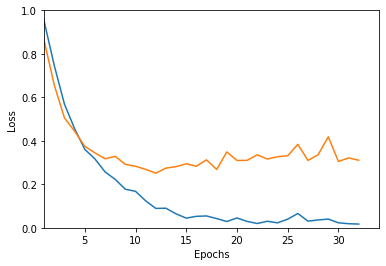

In [60]:
axes = plt.gca()
axes.set_xlim([1,34])
axes.set_ylim([0,1])
plt.plot(train_loss)
plt.plot(valid_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [61]:
class SimpleTestDataset(Dataset):
    def __init__(self, image_ids_df, transform=None):
        self.image_ids = image_ids_df
        self.transform = transform
        
    def __getitem__(self, idx):
        image = cv2.imread(self.image_ids.values[idx])
        
        sample = {
            'image': image,
        }
        
        if self.transform:
            sample = self.transform(**sample)
        
        image = sample['image']
        
        return image
    
    def __len__(self):
        return len(self.image_ids)

In [62]:
test_df = pd.read_csv('test.csv')
test_df['image_id'] = 'images\\' + test_df['image_id'] + '.jpg'

In [63]:
test_df.head()

,image_id
0,images\Test_0.jpg
1,images\Test_1.jpg
2,images\Test_2.jpg
3,images\Test_3.jpg
4,images\Test_4.jpg


In [64]:
test_transform = Compose(
    [
        Resize(224, 224),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        ShiftScaleRotate(rotate_limit=25.0, p=0.7),
        Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225), always_apply=True),
        ToTensor()
    ]
)

In [65]:
test_dataset = SimpleTestDataset(test_df['image_id'], transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [66]:

def test_fn(model):
    predictions = np.zeros((1, 4))
    with torch.no_grad():
        for images in tqdm(test_dataloader):

            images = images.to('cuda')
            model = model.to('cuda')

            preds = model(images)

            predictions = np.concatenate((predictions, preds.cpu().detach().numpy()), 0)
            
    return predictions




In [68]:
test_df = pd.read_csv('test.csv')

# model = EfficientNet.from_pretrained('efficientnet-b4', num_classes=4)
# print('Loading pre-trained model')
# model_ckpt = torch.load('efficientnet-b4.pt')
# print(model.load_state_dict(model_ckpt['state_dict']))

model = torchvision.models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(in_features=1280, out_features=4)
for params in model.parameters():
    params.trainable = False
for params in model.classifier[1].parameters():
    params.trainable = False

print('Loading pre-trained model')
model_ckpt = torch.load('mobilenet-v2-bs-16.pt')
print(model.load_state_dict(model_ckpt['state_dict']))

model = model.cuda()

subs = []
for i in range(3):
    out = test_fn(model)
    output = pd.DataFrame(softmax(out,1), columns = ['healthy','multiple_diseases','rust','scab']) #the submission expects probability scores for each class
    output.drop(0, inplace = True)
    output.reset_index(drop=True,inplace=True)
    subs.append(output)

sub_eff = sum(subs)/10
sub1 = sub_eff.copy()
sub1['image_id'] = test_df.image_id
sub1 = sub1[['image_id','healthy','multiple_diseases','rust','scab']]
sub1.to_csv('submission_mobilenet-v2-bs-16.csv', index = False)

0%|          | 0/114 [00:00<?, ?it/s]Loading pre-trained model
<All keys matched successfully>
100%|██████████| 114/114 [01:15<00:00,  1.50it/s]
